## Student Knowledge Level Model

### Introduction

To score well on a test, it is important that we use a method of study which has historically and scientifically been proven efficient. Is it better to study one night before the exam for an extended period of time or to distribute study sessions in intervals of 30-40 minutes over a couple of days? 

To evaluate this, we decided to do an extensive data analysis to determine the effectiveness of cramming, versus distributed studying. And so we arive at our predictive question of interest:

<i>"What is the level of knowledge that a student has gained from studying, based on their quantity and distribution of study time?"</i>

So we obtained a through dataset from the UCI machine learning repository (Hamdi et al.), which studied how the knowledge status/level of students were related to many potential predictor variables. However, their algorithms using machine learning and neural networks are significantly more complex than ours, and their question is much broader, so we do not actually require all of their variables.

We ultimately only care about the predictor variables concerning study time, and study session distribution. So finally we chose the corresponding variables of STG, which represents a scaled and centralized representation of study time relative to other students, and SCG, which is also a normalized variable that represents the frequency of study sessions for a student. We will study how these two variables correlate with our focus variable of UNS, which represents the knowledge level of the student in their respective subject of interest.

### Methodology and Process

First, we needed to import all of the libraries required for the research of our project:

In [6]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Next we set the seed for this notebook to make the results reproducible.

In [4]:
set.seed(1)

After that, we download the required dataset from the online repository (as read_excel can't directly take urls), and read the file into a dataframe called "knowledge."

In [9]:
URL <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(URL, "data/user_knowledge_data")
knowledge <- read_excel("data/user_knowledge_data", sheet = "Training_Data", range = cell_cols("A:F"))
head(knowledge, 10)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle
0.10,0.10,0.43,0.29,0.56,Middle
0.15,0.02,0.34,0.40,0.01,very_low
0.20,0.14,0.35,0.72,0.25,Low


<b>Table 1</b>

We notice that the UNS variable is currently of character type, but within the context of our question, we want to measure a student's knowledge level based on these distinct labels, so we need to convert the UNS variable into factor type.

In [11]:
knowledge <- mutate(knowledge, UNS = as_factor(UNS))
head(knowledge, 10)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle
0.10,0.10,0.43,0.29,0.56,Middle
0.15,0.02,0.34,0.40,0.01,very_low
0.20,0.14,0.35,0.72,0.25,Low


<b>Table 2</b>

We investigated the distribution of our focus variable, people of various different knowledge levels in the data set. We did this by outputting a table with the number of observations that belonged in each UNS level. If one group is very overrepresented, their data could be much more precise than the other groups, and when paired together, it may yield skewed results.

In [101]:
know_count <- nrow(knowledge)
    knowledge %>%
    group_by(UNS) %>%
    summarize(count = n(),
    percentage = n() / know_count * 100)

`summarise()` ungrouping output (override with `.groups` argument)



UNS,count,percentage
<fct>,<int>,<dbl>
very_low,24,9.302326
High,63,24.418605
Low,83,32.170543
Middle,88,34.108527


<b>Table 3</b>


The result was a fairly even distribution for each category besides for those in the "very low" scores category. This is an acceptable weakness as scorers in the very low section are already expected to be rare, but as long as the other categories are represented correctly, this outlier shouldn't be too significant.


Next we created two histograms to explore the distribution of our predictor variables.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



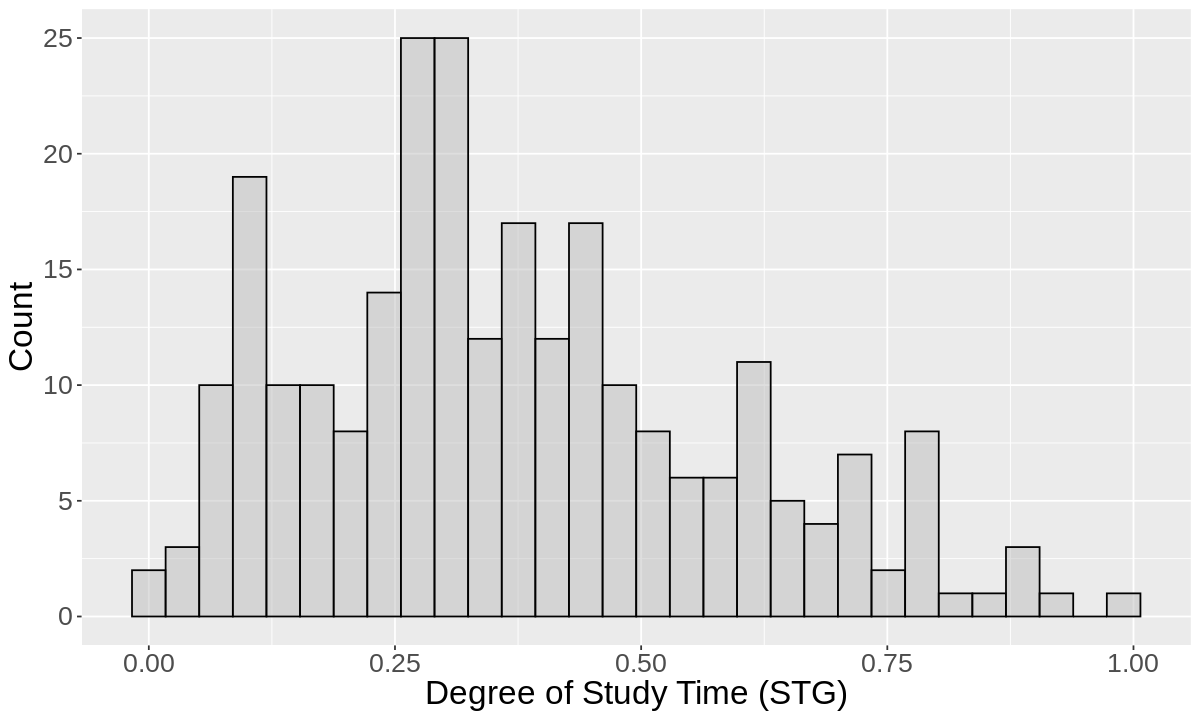

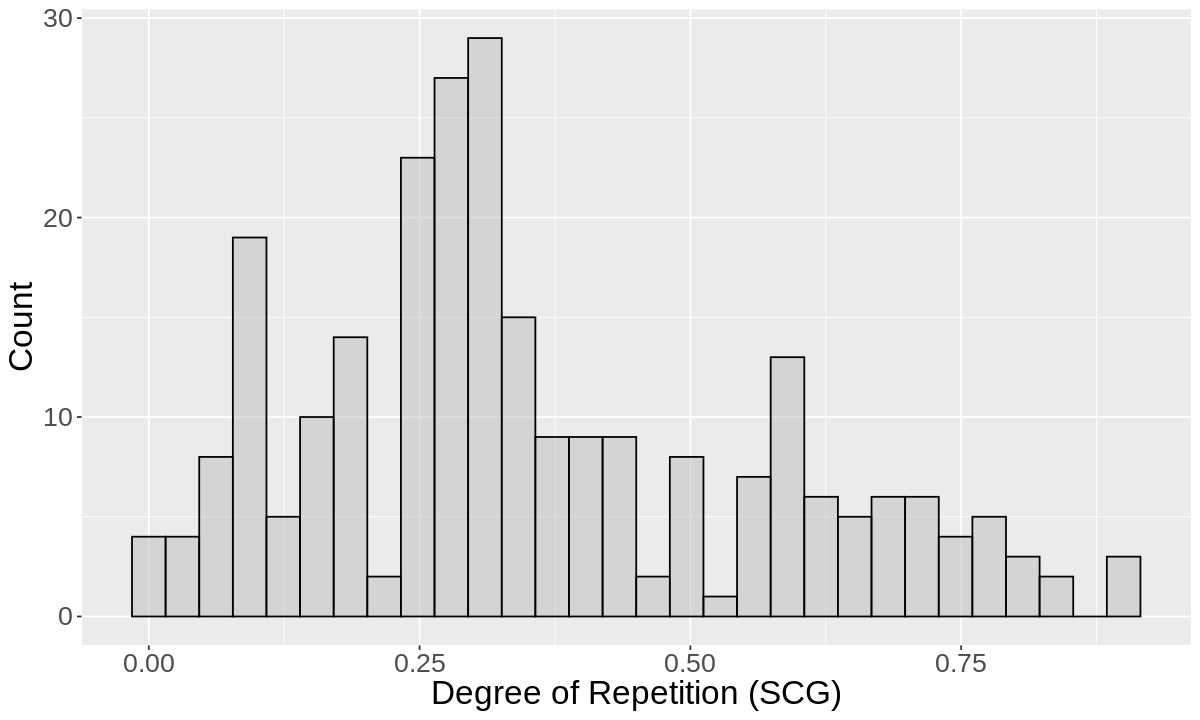

In [15]:
options(repr.plot.width = 10, repr.plot.height = 6)
STG_hist <- ggplot(knowledge, aes(x = STG)) +
    geom_histogram(alpha = 0.5, position = "identity", fill = "gray", color = "black") +
    labs(x = "Degree of Study Time (STG)", 
    y = "Count") +
  theme(text = element_text(size = 20))

SCG_hist <- ggplot(knowledge, aes(x = SCG)) +
    geom_histogram(alpha = 0.5, position = "identity", fill = "gray", color = "black") +
    labs(x = "Degree of Repetition (SCG)", 
    y = "Count") +
    theme(text = element_text(size = 20))

STG_hist
SCG_hist

<b>Img. 1 A (top) and B (bottom)</b>

There is a concentration of values for both variables around the 0.25 zone, but enough values exist at the other distributions that they are not negligible, and the spread is fairly even, so using the entire range of values from the data frame for future steps is acceptable.

After that, we create a scatterplot to obtain a rough overview of how the SCG and STG variables affect student knowledge level. We do this to visually explore the existence of any trends, in order to guide our direction when creating models to answer our predictive question.

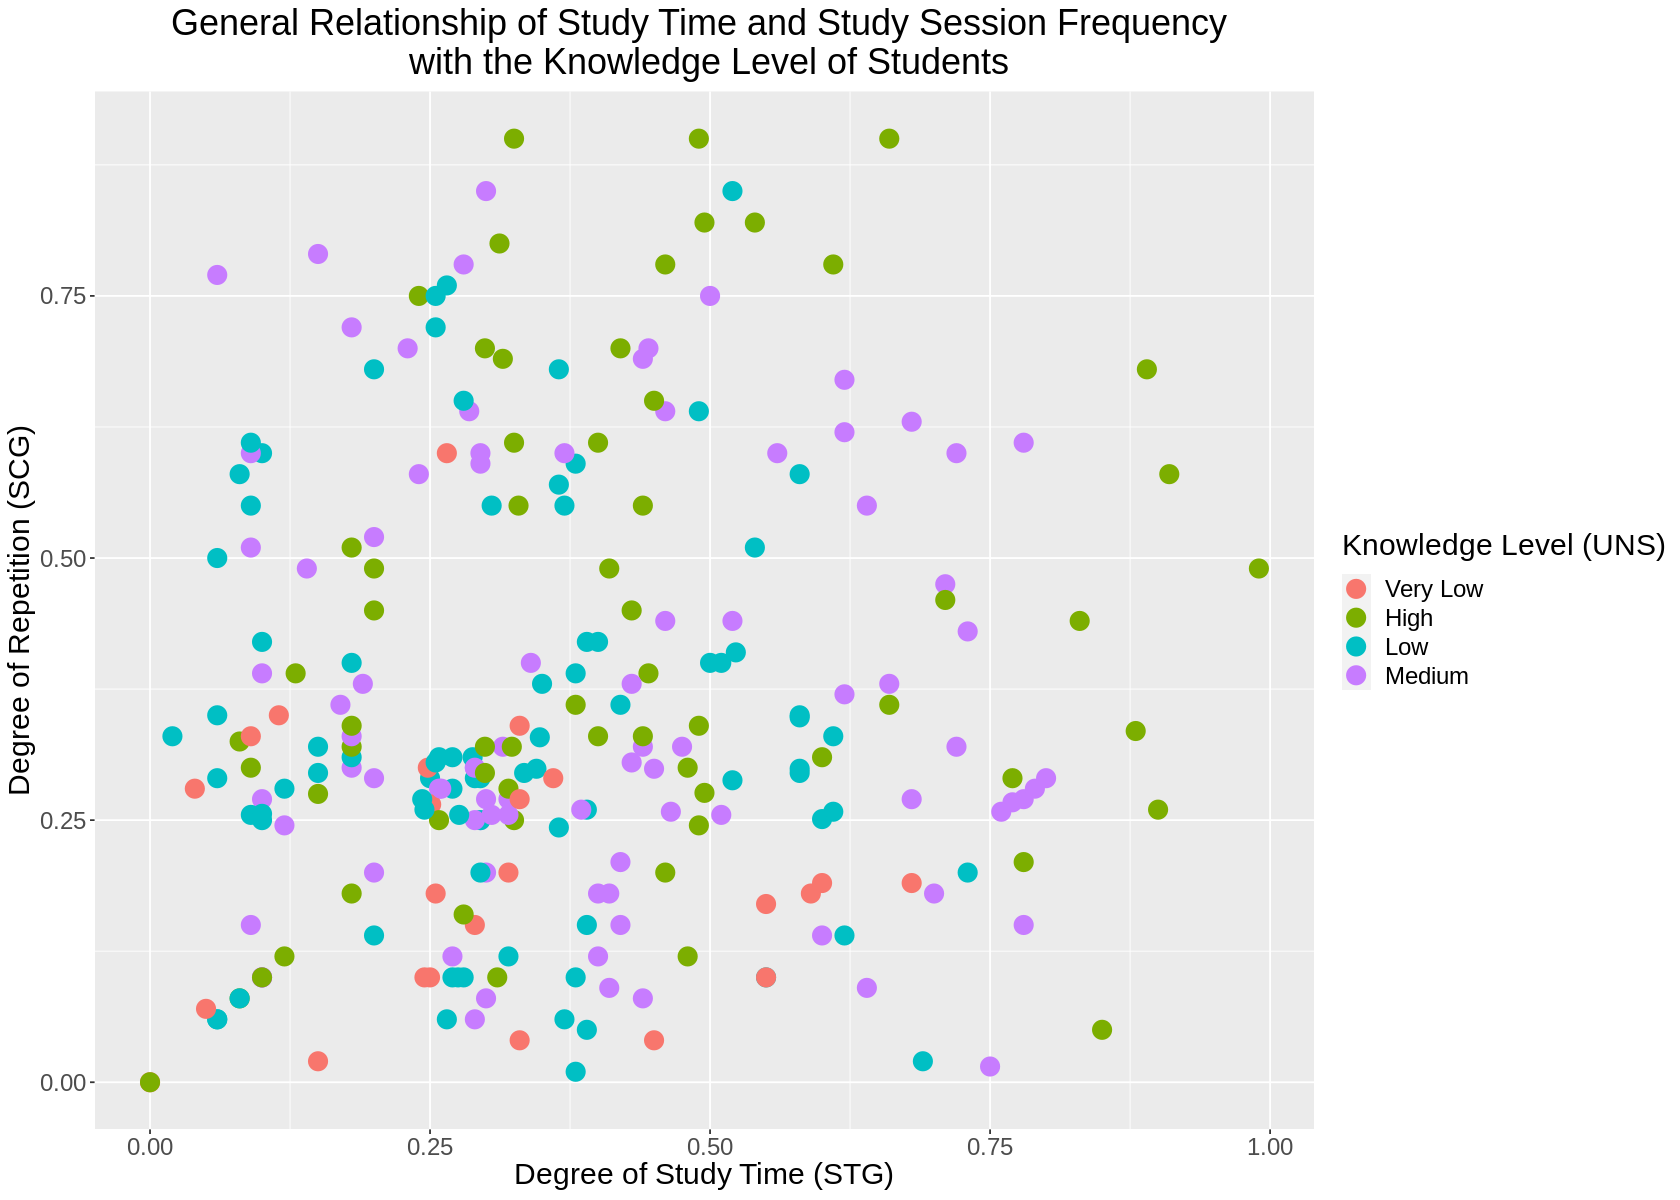

In [26]:
options(repr.plot.width = 14, repr.plot.height = 10)
vis_scatter <- knowledge %>% 
ggplot(aes(x = STG, y = SCG, color = UNS)) +
geom_point(size = 5) +
labs(x = "Degree of Study Time (STG)", y = "Degree of Repetition (SCG)", color = "Knowledge Level (UNS)") +
theme(text = element_text(size = 18), plot.title = element_text(hjust = 0.5)) +
ggtitle("General Relationship of Study Time and Study Session Frequency \n with the Knowledge Level of Students") +
scale_color_discrete(labels = c("Very Low", "High", "Low", "Medium"))

vis_scatter

<b>Image 2</b>

Finally, from this graph, it can be observed that higher study times and higher repetitions when studying do lower the possibility of having lower knowledge levels, which means a relationship exists and our research direction is not meaningless. Our exploration is complete, we have confirmed the relevance of our predictor variables, and we can proceed with creating a model to answer our predictive question.

### Methodology (obsolete)

We focus on two predictor variables: STG- Degree of Study Time & SCG- Degree of Repetition

Our focus variable (UNS) represents knowledge level and is divided into "very low", "low", "medium" and "high".

We are using the k-nearest neighbour classification technique. Where the Euclidean Distance formula: d(x,y) = sqrt((y2 - y1)^2 + (x2 - x1)^2) is used to find the distance between the 5 closest observations from any test point (we chose k = 5 for now, but this may change as we test more k values in the future). Using this technique, we can predict the UNS of a given point on the graph.

To visualize our results, we will graph our results using a colour prediction map, with values in four different areas representing a high likelihood to fall into any of the four respective UNS categories.

### Expected Outcomes and Significance (Obsolete)

We expect to find the relationship between a student’s educational habits and conceptual understanding. Such findings can help change the outlook of what educational habits and study strategies lead to successful learning. Furthermore, our study could give rise to questions such as what is the optimum number of hours or frequency of study sessions for achieving the highest grade.

## Sources

Hamdi Tolga Kahraman, Sagiroglu, S., Colak, I., Developing intuitive knowledge classifier and modeling of users' domain dependent data in web, Knowledge Based Systems, vol. 37, pp. 283-295, 2013.